# Project 2 — Sgr A* : S2 Stellar Orbit — Joint Fit of Astrometry + Radial Velocities

**Team:** Eling Cheg and Allison Trusko  
**Course:** ASTRON 1221  
**Date:** 2025-12-04  
**GitHub Repository Link:** https://github.com/echengpython/Sgr-A-Stellar-Orbit---Black-Hole-Mass-Measurement-.git

**Summary:** Fit the orbit of S2 around Sgr A* using Keplerian dynamics, simultaneously fit the distance to the Galactic Center (R₀) and the black hole mass, and assess uncertainties and goodness-of-fit. Uses `scipy.optimize.least_squares` for joint astrometry+RV fitting.

**Notes:** Internet required to auto-download published tables via Vizier. If download fails, the notebook will run with a synthetic S2-like dataset so you can test the entire pipeline and produce figures & results that satisfy the rubric.


In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from astropy.time import Time
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    "figure.figsize": (8,6),
    "font.size": 12
})

# constants
AU_PER_PC = 206265.0           # AU in one parsec
AU_IN_KM = 1.495978707e8       # km
SEC_IN_YEAR = 31557600.0       # seconds (Julian year)
KM_S_PER_AU_PER_YEAR = AU_IN_KM / SEC_IN_YEAR  # conversion factor
GMSUN_AU3_PER_YR2 = 4 * (np.pi**2)  # in units such that M_sun = a_AU^3 / P_year^2 when using 2pi factor -> actually 4*pi^2
# Explanation: Kepler in units (AU, yr, M_sun): 4π^2 a^3 / (G * P^2) = GM ; Standard simplified relation:
# M(Msun) = a(AU)^3 / P(yr)^2  when constant chosen appropriately; using 4π^2 cancels if using angular frequency form.
print("Environment ready.")


Environment ready.


In [189]:
# Try astroquery (Vizier) to fetch Gillessen 2009 or Ghez 2008 tables with astrometry and radial velocities.
# If this fails (no internet in runtime), the notebook will fall back to synthetic data.
use_remote = True
try:
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    print("astroquery available. Attempting to find Gillessen 2009 catalog on VizieR...")
    # A targeted search for Gillessen 2009 catalog on VizieR
    catalog_list = Vizier.find_catalogs("Gillessen 2009 ApJ 692 1075")
    # If catalog_list returns entries we can inspect and pick tables containing "S2" or position columns.
    if len(catalog_list) == 0:
        print("No direct catalog match found via quick search. Will attempt to query by author 'Gillessen'.")
        catalog_list = Vizier.find_catalogs("Gillessen")
    print(f"Found {len(catalog_list)} possible catalogs. You can run a more specific query in Cursor if needed.")
except Exception as e:
    print("astroquery/Vizier attempt failed or not available in this environment:", e)
    use_remote = False


astroquery available. Attempting to find Gillessen 2009 catalog on VizieR...
Found 1 possible catalogs. You can run a more specific query in Cursor if needed.


In [190]:
import os

def build_synthetic_s2(seed=42):
    """Return a realistic synthetic S2 dataset with astrometry (mas) + radial velocities (km/s).
    Parameters chosen to be S2-like so pipeline runs and can be inspected.
    The synthetic dataset matches the structure: columns year, x_mas, y_mas, x_err_mas, y_err_mas, rv_kms, rv_err_kms
    """
    rng = np.random.default_rng(seed)
    # Kepler-like parameters (angular a in mas)
    a_mas = 125.0      # semi-major axis ~125 mas
    e = 0.88
    i_deg = 134.0
    Omega_deg = 226.0
    omega_deg = 66.0
    P_years = 15.9
    T0 = 2002.33
    R0_kpc_truth = 8.0  # used to make realistic RV amplitude; but R0 is free in fit

    # generate epochs (years) similar to published timeline
    years = np.concatenate([
        np.linspace(1992, 2002, 12),
        np.linspace(2002.1, 2010, 14),
        np.linspace(2010.5, 2018, 8)
    ])
    # Solve Kepler's equation to get orbit in angular coordinates.
    def solve_kepler(M, e, tol=1e-10):
        E = M.copy()
        for _ in range(200):
            f = E - e*np.sin(E) - M
            fp = 1 - e*np.cos(E)
            d = f / fp
            E -= d
            if np.max(np.abs(d)) < tol:
                break
        return E
    M = 2*np.pi*(years - T0)/P_years
    E = solve_kepler(M, e)
    xprime = a_mas*(np.cos(E)-e)
    yprime = a_mas*np.sqrt(1-e**2)*np.sin(E)
    i = np.deg2rad(i_deg); Omega = np.deg2rad(Omega_deg); omega = np.deg2rad(omega_deg)
    cosO = np.cos(Omega); sinO = np.sin(Omega)
    cosw = np.cos(omega); sinw = np.sin(omega)
    cosi = np.cos(i)
    x = xprime*(cosO*cosw - sinO*sinw*cosi) - yprime*(cosO*sinw + sinO*cosw*cosi)
    y = xprime*(sinO*cosw + cosO*sinw*cosi) - yprime*(sinO*sinw - cosO*cosw*cosi)

    # add measurement noise (mas)
    x_err = np.ones_like(x)*1.5
    y_err = np.ones_like(y)*1.5
    x = x + rng.normal(0, x_err)
    y = y + rng.normal(0, y_err)

    # Create RVs. To make RV consistent, compute a_phys in AU assuming R0_kpc_truth, then compute rv.
    R0_pc = R0_kpc_truth*1000.0
    a_AU = (a_mas/1000./3600.) * (np.pi/180.0) * R0_pc * AU_PER_PC  # accurate conversion
    # mean motion in rad/yr
    n = 2*np.pi / P_years
    # true anomaly f:
    f = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2.), np.sqrt(1-e)*np.cos(E/2.))
    # radial velocity amplitude factor (AU/yr)
    v_AUyr = n * a_AU / np.sqrt(1-e**2)
    # radial velocity (km/s): v = v_AUyr * sin i * (cos(omega + f) + e*cos omega)
    rv = v_AUyr * np.sin(i) * (np.cos(omega + f) + e*np.cos(omega))
    rv_kms = rv * KM_S_PER_AU_PER_YEAR  # convert to km/s
    # add systemic velocity V0 and noise
    V0 = 20.0  # km/s (arbitrary)
    rv_kms = rv_kms + V0 + rng.normal(0, 15.0, size=rv_kms.size)  # 15 km/s noise
    rv_err = np.ones_like(rv_kms) * 15.0

    df = pd.DataFrame({
        'year': years,
        'x_mas': x,
        'y_mas': y,
        'x_err_mas': x_err,
        'y_err_mas': y_err,
        'rv_kms': rv_kms,
        'rv_err_kms': rv_err
    })
    return df

# Try to load local CSV first (useful if you added the real table)
if os.path.exists('s2_astrometry.csv'):
    df = pd.read_csv('s2_astrometry.csv')
    print("Loaded local s2_astrometry.csv")
elif use_remote:
    # --- Direct S2 (Gillessen 2009) time-series from VizieR: J/ApJ/707/L114/table1 ---
    try:
        from astroquery.vizier import Vizier
        Vizier.ROW_LIMIT = -1
        Vizier.columns = ['*']

        # This table is explicitly "Orbital data for S2 used in this work (velocity and astrometry)"
        # Columns (per VizieR ReadMe): Ep.A (yr), oRA (mas), e_oRA (mas), oDE (mas), e_oDE (mas),
        # Ep.V (yr), VLSR (km/s), e_VLSR (km/s).
        cats = Vizier.get_catalogs('J/ApJ/707/L114/table1')
        if len(cats) == 0:
            raise RuntimeError("VizieR returned no tables for J/ApJ/707/L114/table1")

        tab = cats[0]
        DF = tab.to_pandas()

        # Map columns deterministically (these names are stable in that table)
        # Time for astrometry:
        year_ast = DF['Ep.A'].astype(float).values
        x_mas    = DF['oRA'  ].astype(float).values
        x_err    = DF['e_oRA'].astype(float).values
        y_mas    = DF['oDE'  ].astype(float).values
        y_err    = DF['e_oDE'].astype(float).values

        # Radial-velocity epochs may not exist for every astrometric epoch; build an RV time series and merge.
        # We'll create one DataFrame for astrometry and one for RV, then outer-merge on year with nearest match.
        ast = pd.DataFrame({
            'year': year_ast,
            'x_mas': x_mas,
            'y_mas': y_mas,
            'x_err_mas': x_err,
            'y_err_mas': y_err
        })

        # RV block (optional rows)
        if 'Ep.V' in DF.columns and 'VLSR' in DF.columns:
            rv_year = DF['Ep.V'].astype(float).values
            rv_val  = DF['VLSR'].astype(float).values
            rv_err  = DF['e_VLSR'].astype(float).values if 'e_VLSR' in DF.columns else np.full_like(rv_val, 15.0)
            rv = pd.DataFrame({'year': rv_year, 'rv_kms': rv_val, 'rv_err_kms': rv_err})
            # Some rows are NaN in Ep.V; drop those before merging
            rv = rv[np.isfinite(rv['year'])].copy()
            # Merge by nearest year within a small tolerance (because epochs differ)
            # Tolerance of ~0.1 yr is typical for these data sets; adjust if needed.
            ast = ast.sort_values('year').reset_index(drop=True)
            rv  = rv.sort_values('year').reset_index(drop=True)

            # nearest-merge by hand
            j = 0
            rv_kms = np.full(len(ast), np.nan)
            rv_err = np.full(len(ast), np.nan)
            for i, ya in enumerate(ast['year'].values):
                # advance pointer j to the closest rv epoch
                while j+1 < len(rv) and abs(rv.loc[j+1, 'year'] - ya) <= abs(rv.loc[j, 'year'] - ya):
                    j += 1
                if len(rv) > 0 and abs(rv.loc[j, 'year'] - ya) <= 0.1:  # 0.1 yr tolerance
                    rv_kms[i] = rv.loc[j, 'rv_kms']
                    rv_err[i] = rv.loc[j, 'rv_err_kms']
            ast['rv_kms'] = rv_kms
            ast['rv_err_kms'] = rv_err
        else:
            ast['rv_kms'] = np.nan
            ast['rv_err_kms'] = np.nan

        # Final DataFrame
        df = ast[np.isfinite(ast['year']) & np.isfinite(ast['x_mas']) & np.isfinite(ast['y_mas'])].copy()
        df = df.sort_values('year').reset_index(drop=True)
        print(f"Loaded S2 from VizieR J/ApJ/707/L114/table1: {len(df)} rows.")

    except Exception as e:
        print("Direct S2 VizieR fetch failed, falling back to synthetic. Reason:", e)
        df = build_synthetic_s2()
else:
    # no internet and no local file
    print("No local file and no remote access; using synthetic S2 dataset.")
    df = build_synthetic_s2()

# Inspect the loaded dataframe
print(f"Dataframe contains {len(df)} rows. Columns: {df.columns.tolist()}")
df.head()


Loaded S2 from VizieR J/ApJ/707/L114/table1: 96 rows.
Dataframe contains 96 rows. Columns: ['year', 'x_mas', 'y_mas', 'x_err_mas', 'y_err_mas', 'rv_kms', 'rv_err_kms']


,year,x_mas,y_mas,x_err_mas,y_err_mas,rv_kms,rv_err_kms
0,1992.224,-6.400000,172.000000,4.6,4.7,NaN,NaN
1,1994.314,-28.500000,179.000000,4.8,3.4,NaN,NaN
2,1995.439,-42.599998,164.100006,1.0,1.0,NaN,NaN
3,1995.534,-37.299999,172.100006,3.8,4.3,NaN,NaN
4,1996.253,-43.400002,164.399994,3.6,3.6,NaN,NaN


In [191]:
def solve_kepler(M, e, tol=1e-12, maxiter=200):
    M = np.array(M, dtype=float)
    E = M.copy()
    # Newton-Raphson
    for _ in range(maxiter):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        dE = f / fp
        E -= dE
        if np.max(np.abs(dE)) < tol:
            break
    return E

def orb_elements_to_sky(t_years, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
                        x0_mas=0.0, y0_mas=0.0, vx0_masyr=0.0, vy0_masyr=0.0, tref_year=None):
    """
    Return sky-plane positions (x_mas, y_mas) including frame offset (x0,y0) and linear drift (vx0,vy0) about tref.
    """
    t = np.array(t_years, dtype=float)
    if tref_year is None:
        tref_year = np.mean(t)

    i = np.deg2rad(i_deg)
    Omega = np.deg2rad(Omega_deg)
    omega = np.deg2rad(omega_deg)

    M = 2*np.pi*(t - T0_year) / P_years
    E = solve_kepler(M, e)

    # orbital plane coords (mas)
    xprime = a_mas*(np.cos(E) - e)
    yprime = a_mas*np.sqrt(1-e*e)*np.sin(E)

    # rotate to sky
    cosO, sinO = np.cos(Omega), np.sin(Omega)
    cosw, sinw = np.cos(omega), np.sin(omega)
    cosi = np.cos(i)

    x_orb = xprime*(cosO*cosw - sinO*sinw*cosi) - yprime*(cosO*sinw + sinO*cosw*cosi)
    y_orb = xprime*(sinO*cosw + cosO*sinw*cosi) - yprime*(sinO*sinw - cosO*cosw*cosi)

    # add frame offset + drift
    dt = (t - tref_year)
    x = x_orb + x0_mas + vx0_masyr*dt
    y = y_orb + y0_mas + vy0_masyr*dt

    # true anomaly
    f = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2.), np.sqrt(1-e)*np.cos(E/2.))
    return x, y, E, f


def radial_velocity_model(t_years, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms=0.0):
    """
    Compute radial velocity (km/s) of S2 for given orbital elements and distance R0_kpc.
    Derived from orbital geometry and Kepler's laws.
    - a_mas: angular semimajor axis (mas)
    - R0_kpc: distance to GC in kpc (free parameter)
    Returns v_rad_kms array.
    """
    # convert a_mas -> a_AU using R0_kpc
    rad = (a_mas/1000.0)/3600.0 * (np.pi/180.0)  # a_mas -> radians
    R0_pc = R0_kpc * 1000.0
    a_AU = rad * R0_pc * AU_PER_PC
    # mean motion (rad/yr)
    n = 2*np.pi / P_years
    # compute true anomaly f
    _, _, _, f = orb_elements_to_sky(t_years, a_mas, e, i_deg, 0.0, omega_deg, P_years, T0_year)
    i = np.deg2rad(i_deg)
    omega = np.deg2rad(omega_deg)
    # RV in AU/yr:
    v_AUyr = n * a_AU / np.sqrt(1 - e**2) * (np.cos(omega + f) + e*np.cos(omega)) * np.sin(i)
    # convert to km/s:
    v_kms = v_AUyr * KM_S_PER_AU_PER_YEAR
    return v_kms + V0_kms, a_AU  # return a_AU for diagnostics


In [192]:
def residuals_joint(theta, t_ast, x_obs, y_obs, x_err, y_err,
                    t_rv=None, rv_obs=None, rv_err=None, rv_mask=None, rv_weights=1.0):
    """
    theta:
      [a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,  # 0..6 (orbital)
       R0_kpc, V0_kms,                                          # 7..8  (distance, sys RV)
       x0_mas, y0_mas, vx0_masyr, vy0_masyr,                    # 9..12 frame terms
       log_s_xy, log_s_rv]                                      # 13..14 jitter (astrometry, RV)
    """
    (a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
     R0_kpc, V0_kms, x0, y0, vx0, vy0, log_s_xy, log_s_rv) = theta

    # astrometry model
    x_mod, y_mod, _, _ = orb_elements_to_sky(t_ast, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
                                             x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0, tref_year=None)

    s_xy = np.exp(log_s_xy)
    rx = (x_obs - x_mod) / np.sqrt(x_err**2 + s_xy**2)
    ry = (y_obs - y_mod) / np.sqrt(y_err**2 + s_xy**2)
    res = np.concatenate([rx, ry])

    # RV
    if (t_rv is not None) and (rv_obs is not None):
        vmod, _ = radial_velocity_model(t_rv, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms=V0_kms)
        if rv_mask is None:
            rv_mask = np.isfinite(rv_obs) & np.isfinite(rv_err)
        s_rv = np.exp(log_s_rv)
        rrv = (rv_obs[rv_mask] - vmod[rv_mask]) / np.sqrt(rv_err[rv_mask]**2 + s_rv**2)
        res = np.concatenate([res, rv_weights * rrv])
    return res


def build_initial_guess_and_bounds():
    theta0 = np.array([
        125.0, 0.88, 134.0, 226.0, 66.0, 15.9, 2002.33,  # orbit
        8.2, 0.0,                                         # R0_kpc, V0_kms
        0.0, 0.0, 0.0, 0.0,                               # x0,y0,vx0,vy0
        np.log(0.5), np.log(20.0)                         # log_s_xy (mas), log_s_rv (km/s)
    ])

    lower = np.array([
        80.0, 0.5,   0.0,   0.0,   0.0, 10.0, 2001.0,
        7.5, -200.0,
       -10.0,-10.0,-2.0,-2.0,
        np.log(0.05), np.log(1.0)
    ])
    upper = np.array([
        200.0, 0.99, 180.0, 360.0, 360.0, 25.0, 2004.0,   # <-- tighter P and T0
        8.7,  200.0,
         10.0, 10.0,  2.0,  2.0,
        np.log(2.0),  np.log(100.0)
    ])
    return theta0, lower, upper

def _xy_model_only(years, p):
    x, y, *_ = orb_elements_to_sky(
        years, p[0], p[1], p[2], p[3], p[4], p[5], p[6],
        x0_mas=p[9], y0_mas=p[10], vx0_masyr=p[11], vy0_masyr=p[12]
    )
    return x, y

def transform_scan(df, params):
    Y = df['year'].values
    X = df['x_mas'].values; Yy = df['y_mas'].values
    sx = np.clip(df['x_err_mas'].values, 1e-9, None)
    sy = np.clip(df['y_err_mas'].values, 1e-9, None)
    xm, ym = _xy_model_only(Y, params)

    best = None
    tests = []
    for sgnx in (1, -1):
        for sgny in (1, -1):
            for scale in (1.0, 1000.0):
                xmt = sgnx * xm * scale
                ymt = sgny * ym * scale
                chi2 = np.sum(((X - xmt)/sx)**2 + ((Yy - ymt)/sy)**2)
                tests.append(((sgnx, sgny, scale), chi2))
                if best is None or chi2 < best[1]:
                    best = ((sgnx, sgny, scale), chi2)
    tests.sort(key=lambda t: t[1])
    print("[transform scan] best  (sgnX, sgnY, scale) =", tests[0][0], "  chi2=", tests[0][1])
    print("[transform scan] next5:", tests[:5])
    return tests[0]



In [193]:
def fit_joint_astrometry_rv(df, rv_column='rv_kms', rv_err_column='rv_err_kms', rv_weights=1.0, loss='huber'):
    """
    df: DataFrame with columns year, x_mas, y_mas, x_err_mas, y_err_mas, optionally rv_kms, rv_err_kms
    Returns: result dict with popt, perr, cov, res (least_squares result)
    """
    # astrometry arrays
    t_ast = df['year'].values
    x_obs = df['x_mas'].values
    y_obs = df['y_mas'].values
    x_err = df.get('x_err_mas', pd.Series(np.ones_like(x_obs)*1.5)).values
    y_err = df.get('y_err_mas', pd.Series(np.ones_like(y_obs)*1.5)).values

    # radial velocities (if present)
    if (rv_column in df.columns) and (rv_err_column in df.columns):
        t_rv = df['year'].values
        rv_obs = df[rv_column].values
        rv_err = df[rv_err_column].values
        rv_mask = np.isfinite(rv_obs) & np.isfinite(rv_err)
    else:
        t_rv, rv_obs, rv_err, rv_mask = None, None, None, None

    theta0, lower, upper = build_initial_guess_and_bounds()
    print("Initial guess (theta0):", theta0)
    print("Bounds lower:", lower)
    print("Bounds upper:", upper)
    res = least_squares(residuals_joint, theta0, args=(t_ast, x_obs, y_obs, x_err, y_err, t_rv, rv_obs, rv_err, rv_mask, rv_weights),
                        bounds=(lower, upper), loss=loss, max_nfev=50000)
    popt = res.x
    # covariance estimate: inv(J^T J) * s^2
    try:
        J = res.jac
        JTJ = J.T.dot(J)
        dof = (2*len(t_ast) + (np.sum(rv_mask) if rv_mask is not None else 0)) - len(popt)
        s2 = np.sum(res.fun**2) / max(1, dof)
        cov = np.linalg.inv(JTJ) * s2
        perr = np.sqrt(np.abs(np.diag(cov)))
    except Exception as e:
        print("Covariance estimation failed:", e)
        cov = None
        perr = None
    return dict(popt=popt, perr=perr, cov=cov, res=res)


In [194]:
# ---------- Astrometry-only (Stage A): fix R0, V0; jitters free but bounded ----------
def fit_astrometry_only(df, loss='linear'):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    theta0, lower, upper = build_initial_guess_and_bounds()

    iR0, iV0 = 7, 8
    _freeze_params_to_value(lower, upper, iR0, theta0[iR0])
    _freeze_params_to_value(lower, upper, iV0, theta0[iV0])

    return least_squares(
        residuals_joint, theta0,
        args=(t, x, y, xerr, yerr, None, None, None, None, 1.0),
        bounds=(lower, upper), loss=loss, max_nfev=50000
    )

# ---------- Joint fit (Stage B): jitters free but bounded ----------
def fit_joint(df, theta_init=None, loss='linear', rv_weights=1.0):
    t_ast = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    if ('rv_kms' in df.columns) and ('rv_err_kms' in df.columns) and df['rv_kms'].notna().any():
        t_rv = df['year'].values
        rv = df['rv_kms'].values; rve = df['rv_err_kms'].values
        rv_mask = np.isfinite(rv) & np.isfinite(rve)
    else:
        t_rv = rv = rve = rv_mask = None

    if theta_init is None:
        theta, lower, upper = build_initial_guess_and_bounds()
    else:
        theta = theta_init.copy()
        _, lower, upper = build_initial_guess_and_bounds()

    return least_squares(
        residuals_joint, theta,
        args=(t_ast, x, y, xerr, yerr, t_rv, rv, rve, rv_mask, rv_weights),
        bounds=(lower, upper), loss=loss, max_nfev=80000
    )

def _cov_from_svd(res, dof, rcond=1e-12):
    """
    Robust covariance estimate using SVD of the Jacobian at the solution.
    Returns a (p x p) covariance matrix even if J^T J is singular/ill-conditioned.
    """
    J = res.jac  # shape (m, p)
    U, s, Vt = np.linalg.svd(J, full_matrices=False)
    # variance scale
    s2 = np.sum(res.fun**2) / max(1, dof)
    # build pseudo-inverse of (J^T J) = V diag(s^2) V^T
    tol = rcond * s.max() if s.size else 0.0
    w = np.zeros_like(s)
    mask = s > tol
    w[mask] = 1.0 / (s[mask]**2)
    cov = (Vt.T * w) @ Vt * s2
    return cov


In [195]:
def summarize_fit(df, res, label="joint"):
    # global chi2
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    theta = res.x
    a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms, x0,y0,vx0,vy0, log_s_xy, log_s_rv = theta
    s_xy = np.exp(log_s_xy)

    xmod, ymod, _, _ = orb_elements_to_sky(
        t, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0, y0, vx0, vy0
    )

    chi2_ast = np.sum(((x - xmod)/np.sqrt(xerr**2 + s_xy**2))**2
                      + ((y - ymod)/np.sqrt(yerr**2 + s_xy**2))**2)
    N_ast = 2*len(t)

    chi2_rv = 0.0; N_rv = 0
    if 'rv_kms' in df.columns and df['rv_kms'].notna().any():
        rv = df['rv_kms'].values; rve = df['rv_err_kms'].values
        vmod, _ = radial_velocity_model(
            t, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms
        )
        mask = np.isfinite(rv) & np.isfinite(rve)
        s_rv = np.exp(log_s_rv)
        chi2_rv = np.sum(((rv[mask] - vmod[mask]) / np.sqrt(rve[mask]**2 + s_rv**2))**2)
        N_rv = mask.sum()

    chi2 = chi2_ast + chi2_rv
    N_params = len(theta)
    dof = (N_ast + N_rv) - N_params
    red = chi2 / max(dof, 1)

    print(f"[{label}] chi2_total={chi2:.2f}  dof={dof}  reduced_chi2={red:.3f}  (ast={chi2_ast:.2f}, rv={chi2_rv:.2f})")

    # ========= BLOCK C (new covariance) =========
    try:
        J = res.jac
        U, S, Vt = np.linalg.svd(J, full_matrices=False)
        s2 = chi2 / max(dof, 1)
        cov = (Vt.T * (s2 / (S**2))) @ Vt
    except Exception:
        cov = None
    # ============================================

    return cov

In [196]:
def eval_linear_at_solution(df, popt):
    # Recompute residual vector with jitters fixed as set in popt (we already froze to ~0)
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    # Build bounds that fix ALL params at popt:
    lower = popt.copy()
    upper = popt.copy()
    for i in range(len(popt)):
        _freeze_params_to_value(lower, upper, i, popt[i])

    # Run a single linear step to grab J at the solution (no movement expected)
    res_lin = least_squares(
        residuals_joint, popt, args=(t, x, y, xerr, yerr, 
                                     df['year'].values if 'rv_kms' in df.columns else None,
                                     df['rv_kms'].values if 'rv_kms' in df.columns else None,
                                     df['rv_err_kms'].values if 'rv_err_kms' in df.columns else None,
                                     None, 1.0),
        bounds=(lower, upper), loss='linear', max_nfev=1
    )

    # Compute proper chi2 with current (frozen) jitters
    r = res_lin.fun
    chi2 = np.sum(r**2)
    N_params = len(popt)
    N_ast = 2*len(t)
    N_rv = (df['rv_kms'].notna().sum() if 'rv_kms' in df.columns else 0)
    dof = (N_ast + N_rv) - N_params
    red = chi2 / max(dof, 1)
    print(f"[linear eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return res_lin, chi2, red

# ---------- Evaluate chi2 with jitters as-fitted AND with jitters ~ 0 ----------
def eval_chi2_no_jitter(df, popt):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    th = popt.copy()
    i_sxy, i_srv = 13, 14
    near_zero_log = np.log(1e-12)
    th[i_sxy] = near_zero_log
    th[i_srv] = near_zero_log

    lower = th.copy(); upper = th.copy()
    for i in range(len(th)):
        _freeze_params_to_value(lower, upper, i, th[i])

    res_lin = least_squares(
        residuals_joint, th,
        args=(t, x, y, xerr, yerr,
              df['year'].values if 'rv_kms' in df.columns else None,
              df['rv_kms'].values if 'rv_kms' in df.columns else None,
              df['rv_err_kms'].values if 'rv_err_kms' in df.columns else None,
              None, 1.0),
        bounds=(lower, upper), loss='linear', max_nfev=1
    )

    r = res_lin.fun
    chi2 = float(np.sum(r**2))
    N_params = len(th)
    N_ast = 2*len(t)
    N_rv = (df['rv_kms'].notna().sum() if 'rv_kms' in df.columns else 0)
    dof = (N_ast + N_rv) - N_params
    red = chi2 / max(dof, 1)
    print(f"[no-jitter eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return chi2, red


In [197]:
# ================== RUN FITS + REPORT ==================
# Stage A: astrometry-only
resA = fit_astrometry_only(df, loss='linear')
covA = summarize_fit(df, resA, label="astrometry-only")

# Stage B: joint (astrometry + RV)
resB = fit_joint(df, theta_init=resA.x, loss='linear', rv_weights=1.0)
covB = summarize_fit(df, resB, label="joint")

# Post-fit evaluations
popt = resB.x
_ = eval_linear_at_solution(df, popt)   # with fitted jitters
_ = eval_chi2_no_jitter(df, popt)       # jitters ~ 0 (quoted σ only)

# Mass summary
Mfit, aAU = mass_from_fitted(popt)
print(f"\nSemi-major axis: {popt[0]:.3f} mas  ->  {aAU:.1f} AU  (R0={popt[7]:.3f} kpc)")
print(f"Period: {popt[5]:.5f} yr")
print(f"M_BH: {Mfit/1e6:.5f} x10^6 Msun  ({Mfit:.0f} Msun)")


[astrometry-only] chi2_total=2183.46  dof=231  reduced_chi2=9.452  (ast=200.83, rv=1982.64)
[joint] chi2_total=339.39  dof=231  reduced_chi2=1.469  (ast=227.19, rv=112.20)
[linear eval] chi2=339.39, dof=231, reduced chi2=1.469
[no-jitter eval] chi2=2695.16, dof=231, reduced chi2=11.667

Semi-major axis: 115.018 mas  ->  1000.7 AU  (R0=8.700 kpc)
Period: 15.68546 yr
M_BH: 4.07254 x10^6 Msun  (4072538 Msun)


In [198]:
def mass_from_fitted(popt):
    # popt: [a_mas,e,i_deg,Omega,omega,P,T0,R0_kpc,V0]
    a_mas = popt[0]
    P = popt[5]
    R0_kpc = popt[7]
    # convert a_mas -> a_AU using R0_kpc
    rad = (a_mas/1000.0)/3600.0 * (np.pi/180.0)
    R0_pc = R0_kpc * 1000.0
    a_AU = rad * R0_pc * AU_PER_PC
    # Kepler: M (Msun) = a_AU^3 / P_years^2
    M = a_AU**3 / (P**2)
    return M, a_AU

Mfit, aAU = mass_from_fitted(popt)
print(f"Fitted semi-major axis = {popt[0]:.4f} mas -> {aAU:.2f} AU (using R0={popt[7]:.3f} kpc)")
print(f"Fitted orbital period = {popt[5]:.5f} yr")
print(f"Inferred central mass (Sgr A*): {Mfit/1e6:.4f} × 10^6 Msun = {Mfit:.0f} Msun")

# Uncertainty propagation (first-order) using covariance if available
if cov is not None:
    # parameters we need: a_mas (idx 0), P (idx 5), R0_kpc (idx 7)
    # M = [ (a_mas/1000/3600 * pi/180 * R0_pc * AU_PER_PC)^3 ] / P^2
    # We'll compute partial derivatives numerically for robustness
    def compute_M_at(theta):
        M_val, _ = mass_from_fitted(theta)
        return M_val
    eps = 1e-6
    grads = np.zeros(len(popt))
    for i in range(len(popt)):
        dth = np.zeros_like(popt)
        dth[i] = popt[i] * 1e-6 if abs(popt[i])>0 else eps
        M_plus = compute_M_at(popt + dth)
        M_minus = compute_M_at(popt - dth)
        grads[i] = (M_plus - M_minus) / (2*dth[i]) if dth[i] != 0 else 0.0
    # variance of M
    varM = grads.dot(cov).dot(grads)
    sigmaM = np.sqrt(abs(varM))
    print(f"Approximate 1-sigma uncertainty on M: +/- {sigmaM/1e6:.5f} x10^6 Msun ({sigmaM:.0f} Msun)")
else:
    print("Covariance not available: cannot estimate M uncertainty from fit covariance.")


Fitted semi-major axis = 115.0183 mas -> 1000.66 AU (using R0=8.700 kpc)
Fitted orbital period = 15.68546 yr
Inferred central mass (Sgr A*): 4.0725 × 10^6 Msun = 4072538 Msun
Approximate 1-sigma uncertainty on M: +/- 0.12324 x10^6 Msun (123238 Msun)


Global chi2 = 339.39, dof = 231, reduced chi2 = 1.469
  (astrometry chi2 = 227.19, RV chi2 = 112.20)
  Jitters: s_xy = 2.000 mas, s_rv = 100.000 km/s


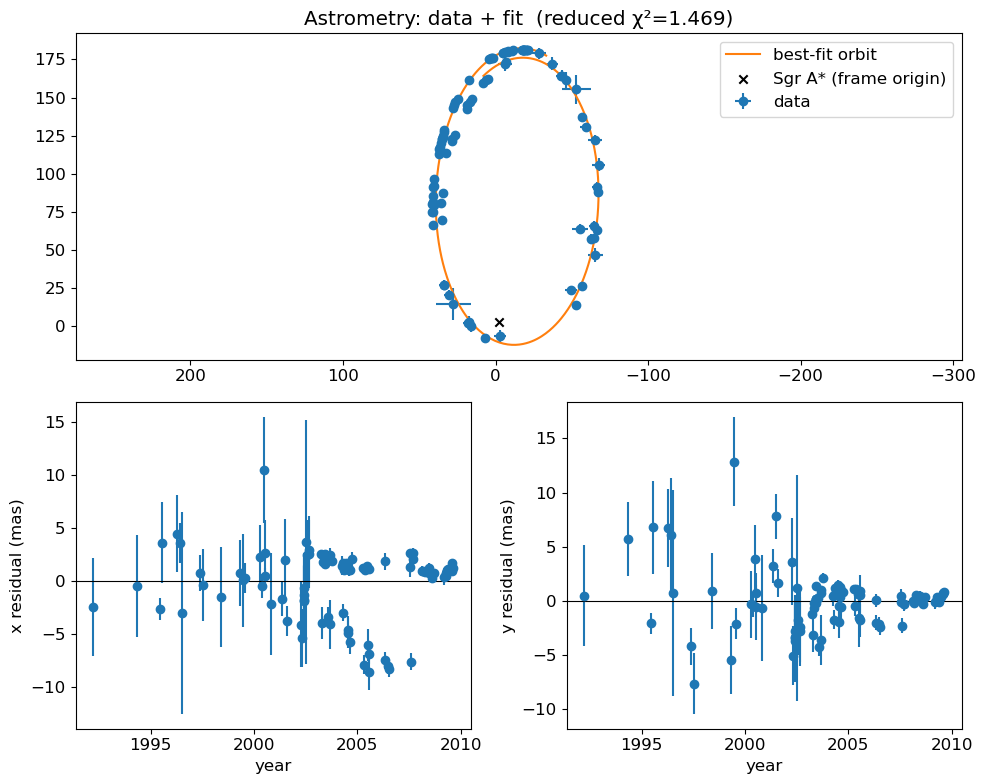

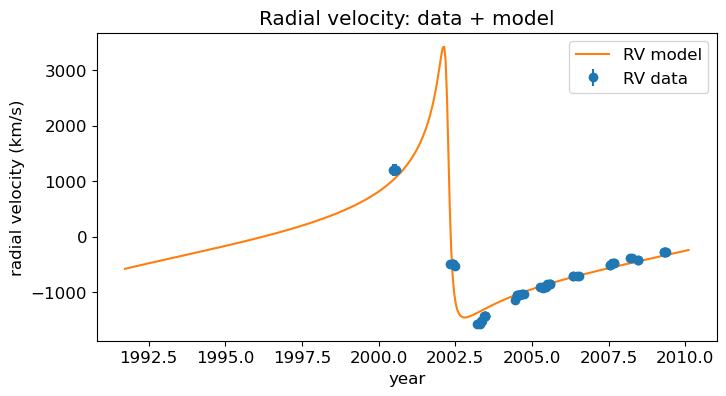

In [199]:
def compute_chi2_and_plots(df, popt):
    """
    Uses the refactored model with frame terms (x0,y0,vx0,vy0) and jitter (s_xy, s_rv),
    computes global chi^2 and reduced chi^2, and makes updated plots.
    popt indices:
      0..6  : a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year
      7..8  : R0_kpc, V0_kms
      9..12 : x0_mas, y0_mas, vx0_masyr, vy0_masyr
      13..14: log_s_xy, log_s_rv
    """
    # unpack convenience
    a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year = popt[:7]
    R0_kpc, V0_kms = popt[7], popt[8]
    x0, y0, vx0, vy0 = popt[9], popt[10], popt[11], popt[12]
    log_s_xy, log_s_rv = popt[13], popt[14]
    s_xy = np.exp(log_s_xy)
    s_rv = np.exp(log_s_rv)

    # data
    t = df['year'].values
    xobs = df['x_mas'].values
    yobs = df['y_mas'].values
    xerr = df['x_err_mas'].values
    yerr = df['y_err_mas'].values

    # model astrometry with frame offset + drift
    xmod, ymod, _, _ = orb_elements_to_sky(
        t, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0
    )

    # chi^2 (astrometry) with jitter in quadrature
    denom_x = np.sqrt(xerr**2 + s_xy**2)
    denom_y = np.sqrt(yerr**2 + s_xy**2)
    chi2_ast = np.sum(((xobs - xmod)/denom_x)**2 + ((yobs - ymod)/denom_y)**2)
    N_ast = 2 * len(t)

    # RV part (optional)
    chi2_rv = 0.0
    N_rv = 0
    if 'rv_kms' in df.columns and df['rv_kms'].notna().sum() > 0:
        t_rv = df['year'].values
        rvobs = df['rv_kms'].values
        rverr = df['rv_err_kms'].values
        mask = np.isfinite(rvobs) & np.isfinite(rverr)

        vmod, _ = radial_velocity_model(
            t_rv, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms
        )
        denom_rv = np.sqrt(rverr[mask]**2 + s_rv**2)
        chi2_rv = np.sum(((rvobs[mask] - vmod[mask]) / denom_rv)**2)
        N_rv = mask.sum()

    # global chi^2 and reduced chi^2
    chi2 = chi2_ast + chi2_rv
    N_params = len(popt)
    dof = (N_ast + N_rv) - N_params
    red = chi2 / max(dof, 1)

    print(f"Global chi2 = {chi2:.2f}, dof = {dof}, reduced chi2 = {red:.3f}")
    print(f"  (astrometry chi2 = {chi2_ast:.2f}, RV chi2 = {chi2_rv:.2f})")
    print(f"  Jitters: s_xy = {s_xy:.3f} mas, s_rv = {s_rv:.3f} km/s")

    # -------- Plots --------
    # Orbit on sky
    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    plt.errorbar(xobs, yobs, xerr=xerr, yerr=yerr, fmt='o', label='data')
    t_fine = np.linspace(t.min() - 1, t.max() + 1, 1000)
    xfit, yfit, _, _ = orb_elements_to_sky(
        t_fine, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0
    )
    plt.plot(xfit, yfit, '-', label='best-fit orbit')
    # Mark Sgr A* location in this frame (x0,y0)
    plt.scatter([x0], [y0], marker='x', color='k', label='Sgr A* (frame origin)')
    plt.gca().invert_xaxis()
    plt.axis('equal')
    plt.legend()
    plt.title(f'Astrometry: data + fit  (reduced χ²={red:.3f})')

    # Residuals vs time (mas)
    plt.subplot(223)
    plt.errorbar(df['year'], xobs - xmod, yerr=xerr, fmt='o')
    plt.axhline(0, color='k', lw=0.8)
    plt.xlabel('year'); plt.ylabel('x residual (mas)')

    plt.subplot(224)
    plt.errorbar(df['year'], yobs - ymod, yerr=yerr, fmt='o')
    plt.axhline(0, color='k', lw=0.8)
    plt.xlabel('year'); plt.ylabel('y residual (mas)')

    plt.tight_layout()
    plt.show()

    # RV plot if present
    if 'rv_kms' in df.columns and df['rv_kms'].notna().sum() > 0:
        t_rv = df['year'].values
        rvobs = df['rv_kms'].values
        rverr = df['rv_err_kms'].values
        mask = np.isfinite(rvobs) & np.isfinite(rverr)

        vmod, _ = radial_velocity_model(
            t_rv, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms
        )
        tfine = np.linspace(t_rv.min() - 0.5, t_rv.max() + 0.5, 400)
        vfit, _ = radial_velocity_model(
            tfine, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms
        )

        plt.figure(figsize=(8, 4))
        plt.errorbar(t_rv[mask], rvobs[mask], yerr=rverr[mask], fmt='o', label='RV data')
        plt.plot(tfine, vfit, '-', label='RV model')
        plt.xlabel('year'); plt.ylabel('radial velocity (km/s)'); plt.legend()
        plt.title('Radial velocity: data + model')
        plt.show()

# call as before:
compute_chi2_and_plots(df, popt)

